In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import keras.backend as K
from tensorflow.keras.applications import densenet
import tensorflow.keras.layers as kl
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Layer
#import keras_tuner
import humanfriendly
import itertools
import sklearn.metrics
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split, GroupShuffleSplit
#from keras_tuner.tuners import BayesianOptimization
#from keras_tuner import Objective
#from keras_tuner_cv.utils import pd_inner_cv_get_result

#Optimizer options
from tensorflow.keras.optimizers import Adam

2024-07-29 11:09:47.658383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 11:09:49.899639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.utils import resample

In [3]:
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from skimage import exposure
from skimage.exposure import match_histograms

import collections
collections.Iterable = collections.abc.Iterable
import numpy as np
import random
np.bool = np.bool_
np.complex = np.complex_

import argparse
import os
import sys
import time

In [4]:
os.chdir("/localscratch/hrechter.23673475.0")

In [6]:
crop = cv2.imread(('crops/SV_TRV006_2022-06-18-20-25-02_DCIM9010_bear_mask.png'), cv2.IMREAD_UNCHANGED)
cv2.imshow('RGB Image',crop)

[ WARN:0@37.707] global /home/moroub/wheels_builder/tmp.15724/python-3.10/opencv-python-headless-4.6.0.66/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('crops/SV_TRV006_2022-06-18-20-25-02_DCIM9010_bear_mask.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /home/moroub/wheels_builder/tmp.15724/python-3.10/opencv-python-headless-4.6.0.66/opencv/modules/highgui/src/window.cpp:967: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


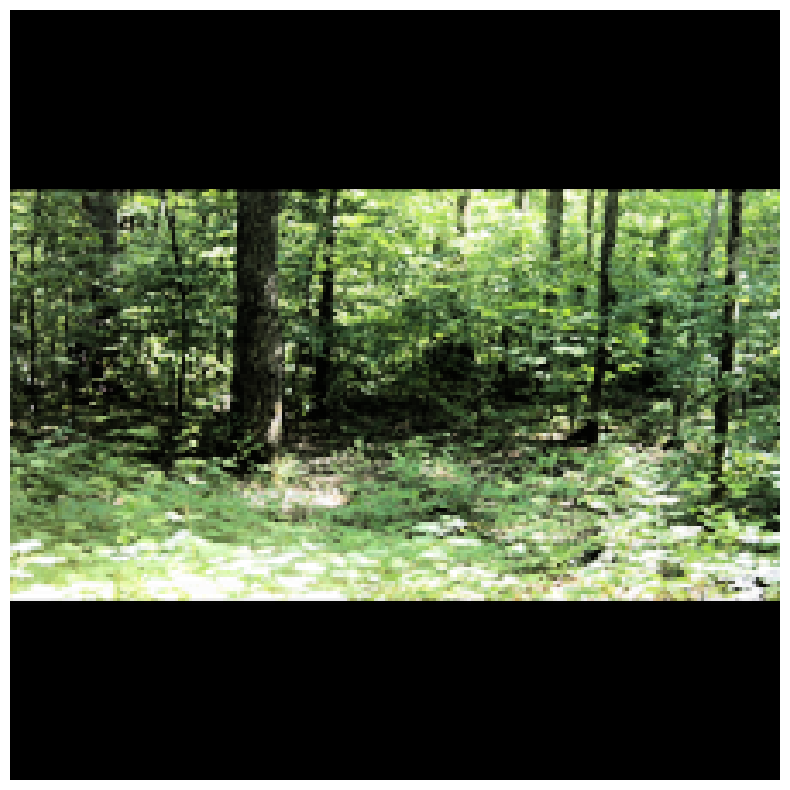

In [5]:
image = cv2.imread("AHC/Gladstone/GL_RAF001/GL_RAF001_2022-08-15-10-00-00_DCIM0099.png")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Equalise channel V
img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])

# Convert to RGB
image = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
#%%
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
#%% Define mask insertion function
'''
Function from StackOverflow user Ben: https://stackoverflow.com/users/59850/ben
https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
'''
def add_transparent_image(background, foreground, x_offset=None, y_offset=None):
    bg_h, bg_w, bg_channels = background.shape
    fg_h, fg_w, fg_channels = foreground.shape

    assert bg_channels == 3, f'background image should have exactly 3 channels (RGB). found:{bg_channels}'
    assert fg_channels == 4, f'foreground image should have exactly 4 channels (RGBA). found:{fg_channels}'

    # center by default
    if x_offset is None: 
        x_offset = (bg_w - fg_w) // 2
    else:
        centre_x = (bg_w - fg_w) // 2
        x_offset = x_offset + centre_x
        
    if y_offset is None: 
        y_offset = (bg_h - fg_h) // 2
    else:
        centre_y = (bg_h - fg_h) // 2
        y_offset = y_offset + centre_y

    w = min(fg_w, bg_w, fg_w + x_offset, bg_w - x_offset)
    h = min(fg_h, bg_h, fg_h + y_offset, bg_h - y_offset)

    if w < 1 or h < 1: return

    # clip foreground and background images to the overlapping regions
    bg_x = max(0, x_offset)
    bg_y = max(0, y_offset)
    fg_x = max(0, x_offset * -1)
    fg_y = max(0, y_offset * -1)
    foreground = foreground[fg_y:fg_y + h, fg_x:fg_x + w]
    background_subsection = background[bg_y:bg_y + h, bg_x:bg_x + w]

    # separate alpha and color channels from the foreground image
    foreground_colors = foreground[:, :, :3]
#    foreground_colors = match_histograms(foreground_colors, background, channel_axis=-1)
    alpha_channel = foreground[:, :, 3] / 255  # 0-255 => 0.0-1.0

    # construct an alpha_mask that matches the image shape
    alpha_mask = np.dstack((alpha_channel, alpha_channel, alpha_channel))

    # combine the background with the overlay image weighted by alpha
    composite = background_subsection * (1 - alpha_mask) + foreground_colors * alpha_mask

    # overwrite the section of the background image that has been updated
    background[bg_y:bg_y + h, bg_x:bg_x + w] = composite
    return background

In [7]:
#%% Define augmentation functions
mask_augs = iaa.Sequential([iaa.Resize((0.45, 0.85), interpolation="area"), #area interpolation is best for shrinking images
        iaa.SomeOf((1, 2), [  # Random number between 0, 2
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Rotate((-10, 10)),
        ], random_order=True)], random_order = True)

Winter_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.weather.Clouds(),
        iaa.weather.Fog(),
        iaa.weather.Snowflakes()
        ], random_order=True)

small_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Grayscale(alpha=(0.1, 1.0)),  # Random Grayscale conversion          0.17        
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        ], random_order=True)

train_aug = iaa.SomeOf((1, 3), [  # Random number between 0, 3
        iaa.Fliplr(0.5),  # Horizontal flips                     0.01
        iaa.Add((-5, 5)),  # Overall Brightness                   0.04
        iaa.Multiply((0.95, 1.05), per_channel=0.2),  # Brightness multiplier per channel    0.05
        iaa.Sharpen(alpha=(0.1, 0.75), lightness=(0.85, 1.15)),  # Sharpness                            0.05
        iaa.GammaContrast((0.5, 2.0)),
        iaa.WithHueAndSaturation([iaa.WithChannels(0, iaa.Add((-15, 15))), 
                                 iaa.WithChannels(1, [iaa.Multiply((0.5, 1.5)), iaa.LinearContrast((0.75, 1.25))])]),
        iaa.AddElementwise((-10, 10), per_channel=0.5),  # Per pixel addition                   0.11
        iaa.CoarseDropout((0.0, 0.02), size_percent=(0.02, 0.25)),  # Add large black squares              0.13
        iaa.GaussianBlur(sigma=(0.1, 1.0)),  # GaussianBlur                         0.14
        iaa.Dropout(p=(0, 0.1), per_channel=0.2),  # Add small black squares              0.17
        iaa.AdditiveGaussianNoise(scale=(0.0, 0.05 * 255), per_channel=0.5),  # Add Gaussian per pixel noise         0.26
        iaa.ElasticTransformation(alpha=(0, 1.0), sigma=0.25),  # Distort image by rearranging pixels  0.70
        iaa.LinearContrast((0.75, 1.5)),  # Contrast Normalization               0.95
        iaa.weather.Clouds(),
  #      iaa.weather.Rain()
    ], random_order=True)

insert_augs = iaa.ChangeColorTemperature((1100, 4000))
insertblur = iaa.Sequential([iaa.GaussianBlur(sigma=(0.1, 0.2))])
nightnoise = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=(0, 5))])

In [58]:
#%%
class TrainingDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, crops, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True, INSERTS=False, SPP_BAL=False,
                 weights=None, night_weights=None):

        self.df = df.copy()
        self.crops = crops.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.INSERTS=INSERTS
        self.n = len(self.df)
        if self.INSERTS==False:
            self.n_id = df[y_col['id']].nunique()
        elif self.INSERTS==True:
            self._weights=weights
            self._night_weights=night_weights
            if self.df['id'].isin([-2]).any():
                self.n_id = ((df[y_col['id']].nunique())-2)
                if SPP_BAL == False:
                    self._weights=weights
                    self._night_weights=night_weights
                else:
                    self._weights=None
                    self._night_weights=None
            else:
                self.n_id = ((df[y_col['id']].nunique())-1)
      #      if self.n_id>12:
      #          day_choices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 28, 29, 30, 31, 32, 33, 34, 35]
      #          night_choices=[0, 1, 2, 4, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33]
        self.n_domain = df[y_col['domain']].nunique()


    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __insert_augs(self, path, night, spp):
 #       start_time = time.time()
        if spp==-1:
            if night==False:
        #        rolld8=np.random.choice([0, 1, 2, 3, 4, 5, 6, 7], p=self._weights)
                rolld8=(random.choices([0, 1, 2, 3, 4, 5, 6], weights=self._weights, k=1))[0]
          #      if rolld8==0:
           #         image = tf.keras.utils.load_img(path)
            #        image_arr = tf.keras.utils.img_to_array(image)
             #       species=0
            #        SKIP = time.time() - start_time
            #        print(('SKIP: {}.').format(SKIP))
              #      return image_arr, species
#                SELECT = time.time()
                crop_index = self.crops.loc[(self.crops.Night==False) & (self.crops.id==rolld8)].sample(n=1).index.item()
#                SELECT_IMAGE = time.time() - SELECT
 #               FIND_INDEX = time.time() - start_time
  #              print(('SELECT IMAGE time: {}.').format(SELECT_IMAGE))
   #             print(('FIND DAY INDEX time: {}.').format(FIND_INDEX))
    #            insert_start = time.time()
                cpath = self.crops.iloc[crop_index, 0]
     #           READ_CPATH = time.time() - insert_start
      #          print(('READ CROP PATH time: {}.').format(READ_CPATH))
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
       #         openCROP = time.time() - insert_start
        #        print(('OPEN CROP time: {}.').format(openCROP))
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                reference = cv2.imread(path)
                reference = reference[52:172, 0:224]
                alpha = crop[:,:,3] # get alpha channel
                crop = cv2.cvtColor(crop, cv2.COLOR_BGRA2BGR)
                crop2 = match_histograms(crop, reference, channel_axis=-1)
                crop = cv2.addWeighted(crop2, 1.0, crop, 0.5, 1.0)
                crop = cv2.cvtColor(crop, cv2.COLOR_BGR2BGRA)
                crop[:, :, 3] = alpha
                
                crop_aug = mask_augs.augment_image(crop)
#                augCROP = time.time() - insert_start
 #               print(('AUGMENT CROP time: {}.').format(augCROP))
                
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
  #              OPEN_IMPATH = time.time() - insert_start
   #             print(('OPEN IMAGE PATH time: {}.').format(OPEN_IMPATH))
    #            ADD_TRANSPARENT_START = time.time()
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
                rolld1000=random.randint(1, 1001)
                if rolld1000==1000: #Save 1% of created images for verification
                    file = path.rsplit('/')[-1]
                    spp_name = self.crops.iloc[crop_index, 2]
                    if not os.path.exists("Results/augmentations5/"):
                        os.makedirs("Results/augmentations5/")
                    cv2.imwrite("Results/augmentations5/early_" + spp_name + "_" + file, image)
     #           ADD_TRANSPARENT_ELAPSED = time.time() - ADD_TRANSPARENT_START
      #          print(('Add_transparent_image DAY time: {}.').format(ADD_TRANSPARENT_ELAPSED))
    
                # Convert to HSV (Hue Saturation Value)
#                img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

                # Equalise channel V
#                img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])

                # Convert to RGB
#                image = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
            elif night==True:
           #     nightd7=np.random.choice([0, 1, 2, 3, 4, 6, 7], p=self._night_weights)
                nightd7=(random.choices([0, 1, 2, 3, 5, 6], weights=self._night_weights, k=1))[0]
          #      if nightd7==0:
           #         image = tf.keras.utils.load_img(path)
            #        image_arr = tf.keras.utils.img_to_array(image)
             #       species=0
#                    SKIP = time.time() - start_time
 #                   print(('SKIP: {}.').format(SKIP))
              #      return image_arr, species
#                SELECT = time.time()
                crop_index = self.crops.loc[(self.crops.Night==True) & (self.crops.id==nightd7)].sample(n=1).index.item()
 #               SELECT_IMAGE = time.time() - SELECT
  #              FIND_INDEX = time.time() - start_time
   #             print(('SELECT IMAGE time: {}.').format(SELECT_IMAGE))
    #            FIND_INDEX = time.time() - start_time
     #           print(('----------------find night index time: {}.').format(FIND_INDEX))
      #          insert_start = time.time()
                cpath = self.crops.iloc[crop_index, 0]
#                READ_CPATH = time.time() - insert_start
 #               print(('READ CROP PATH time: {}.').format(READ_CPATH))
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
  #              openCROP = time.time() - insert_start
   #             print(('OPEN CROP time: {}.').format(openCROP))
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                crop_aug = mask_augs.augment_image(crop)
                
    #            augCROP = time.time() - insert_start
     #           print(('AUGMENT CROP time: {}.').format(augCROP))
                
                
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
#                READ_PATH = time.time() - insert_start
                image = cv2.imread(path)
 #               OPEN_IMPATH = time.time() - insert_start
  #              print(('OPEN IMAGE PATH time: {}.').format(OPEN_IMPATH))
   #             ADD_TRANSPARENT_START = time.time()
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)

    #            ADD_TRANSPARENT_ELAPSED = time.time() - ADD_TRANSPARENT_START
     #           print(('----------------Add_transparent_image night time: {}.').format(ADD_TRANSPARENT_ELAPSED))
                image = nightnoise.augment_image(image)
#            FINAL_MODS_START = time.time()
            image = cv2.rectangle(image, (0,0), (244,52), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            image = cv2.rectangle(image, (0,172), (244,244), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
 #           FINAL_MODS = time.time() - FINAL_MODS_START
  #          print(('BLACKOUT BARS time: {}.').format(FINAL_MODS))
            
            rolld1000=random.randint(1, 1001)
            if rolld1000==1000: #Save 1% of created images for verification
   #             start_save = time.time()
                file = path.rsplit('/')[-1]
                spp_name = self.crops.iloc[crop_index, 2]
                if not os.path.exists("Results/augmentations/"):
                    os.makedirs("Results/augmentations/")
                cv2.imwrite("Results/augmentations/" + spp_name + "_" + file, image)
    #            SAVE_elapsed = time.time() - start_save
     #           print(('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>d100 save time: {}.').format(SAVE_elapsed))
            image_arr = image.astype("float32")
            species = self.crops.iloc[crop_index, 3]
      #      INSERT_elapsed = time.time() - insert_start
       #     AUGMENT_elapsed = time.time() - start_time
        #    print(('Animal Insert time: {}.').format(INSERT_elapsed))
         #   print(('FULL AUGMENTATION time: {}.').format(AUGMENT_elapsed))
            return image_arr, species
        if spp==-2:
            if night==False:
                rolld8=(random.choices([0, 1, 2, 3, 4, 5, 6], weights=self._weights, k=1))[0]
   #             if rolld8==0:
    #                image = tf.keras.utils.load_img(path)
     #               image_arr = tf.keras.utils.img_to_array(image)
      #              species=0
       #             return image_arr, species

                crop_index = self.crops.loc[(self.crops.Night==False) & (self.crops.id==rolld8)].sample(n=1).index.item()
                cpath = self.crops.iloc[crop_index, 0]
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]
                reference = cv2.imread(path)

                crop = match_histograms(crop, reference, channel_axis=-1)                
                crop_aug = mask_augs.augment_image(crop)
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
                
                rolld1000=random.randint(1, 1001)
                if rolld1000==1000: #Save 1% of created images for verification
                    file = path.rsplit('/')[-1]
                    spp_name = self.crops.iloc[crop_index, 2]
                    if not os.path.exists("Results/augmentations2/"):
                        os.makedirs("Results/augmentations2/")
                    cv2.imwrite("Results/augmentations2/early_" + spp_name + "_" + file, image)
                # Convert to HSV (Hue Saturation Value)
   #             img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

                # Equalise channel V
#                img_hsv[:,:,2] = cv2.equalizeHist(img_hsv[:,:,2])

                # Convert to RGB
#                image = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
            elif night==True:
                nightd7=(random.choices([0, 1, 2, 3, 5, 6], weights=self._night_weights, k=1))[0]
               # if nightd7==0:
                #    image = tf.keras.utils.load_img(path)
                 #   image_arr = tf.keras.utils.img_to_array(image)
                  #  species=0
                   # return image_arr, species

                crop_index = self.crops.loc[(self.crops.Night==True) & (self.crops.id==nightd7)].sample(n=1).index.item()
                cpath = self.crops.iloc[crop_index, 0]
                crop = cv2.imread(('crops/' + cpath), cv2.IMREAD_UNCHANGED)
                spp_name = self.crops.iloc[crop_index, 2]
                species = self.crops.iloc[crop_index, 3]

                crop_aug = mask_augs.augment_image(crop)
                y_jitter=random.randint(-7, 40)
                x_jitter=random.randint(-85, 85)
                image = cv2.imread(path)
                image = add_transparent_image(image, crop_aug, x_offset=x_jitter, y_offset=y_jitter)
                image = nightnoise.augment_image(image)

            image = cv2.rectangle(image, (0,0), (244,52), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            image = cv2.rectangle(image, (0,172), (244,244), (0,0,0), -1) # 52 pixels on top and bottom Black infobar)
            
            rolld1000=random.randint(1, 1001)
            if rolld1000==1000: #Save 1% of created images for verification
                file = path.rsplit('/')[-1]
                spp_name = self.crops.iloc[crop_index, 2]
                if not os.path.exists("Results/augmentations2/"):
                    os.makedirs("Results/augmentations2/")
                cv2.imwrite("Results/augmentations2/" + spp_name + "_" + file, image)

            image_arr = image.astype("float32")
            species = self.crops.iloc[crop_index, 3]
            return image_arr, species

    #Reads image and normalizes it
    def __get_input(self, path):
        image = tf.keras.utils.load_img(path)
        image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        return image_arr/255

    #Reads image and normalizes it
    def __get_insert_input(self, x):
        path=x[0]
        night=x[1]
        spp=x[2]

        if spp in (-1, -2):
            image_arr, x[2] = self.__insert_augs(path, night, spp)
        else:
            image = tf.keras.utils.load_img(path)
            image_arr = tf.keras.utils.img_to_array(image)
        image_arr = small_aug.augment_image(image_arr.astype("uint8")).astype("float32")
        spp = x[2]
        label = tf.keras.utils.to_categorical(spp, 7)
        return image_arr/255, label

    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)

    #Generates batch_size samples of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]

        if self.INSERTS==True:
            night_batch = batches[self.X_col['Night']]
            x_batches=np.array([path_batch, night_batch, name_batch])
            x_batches=np.stack(x_batches,axis=1)

            batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])
            X_batch, y0_batch = zip(*batch_tuple)
            X_batch = np.array(X_batch)
            y0_batch= np.array(y0_batch)

        else:
            X_batch = np.asarray([self.__get_input(x) for x in path_batch])
            y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])

    #Returns data batches as tuple
    def __getitem__(self, index):

        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    

        return X, y

    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [59]:
class ValidationDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size, model_name,
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.model = model_name
        self.n = len(self.df)
        self.n_id = ((df[y_col['id']]).nunique())
        self.n_domain = df[y_col['domain']].nunique()
    # Shuffling upon epoch end if flagged
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    #Reads image and normalizes it
    def __get_input(self, path):

        image = tf.keras.utils.load_img(path)
        image_arr = tf.keras.utils.img_to_array(image)
        return image_arr/255.
   
    #One-hot encoding of label
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    #Generates batches of data
    def __get_data(self, batches):
        # Generates data containing batch_size samples
        path_batch = batches[self.X_col['path']]
        name_batch = batches[self.y_col['id']]
        X_batch = np.asarray([self.__get_input(x) for x in path_batch])
        y0_batch = np.asarray([self.__get_output(y, self.n_id) for y in name_batch])

        if self.model in ('DenseNet201', 'CNN'):
            return X_batch, y0_batch
        elif self.model in ('DANNseNet201', 'DANN'):
            sin_season_batch = batches[self.y_col['sin_date']]
            cos_season_batch = batches[self.y_col['cos_date']]
            y1_batch = np.asarray([y for y in zip(sin_season_batch, cos_season_batch)])
            return X_batch, tuple([y0_batch, y1_batch])
        elif self.model in ('CatDANN', 'catDANN'):
            domain_batch = batches[self.y_col['domain']]
            y1_batch = np.asarray([self.__get_output(y, 4) for y in domain_batch])
            return X_batch, tuple([y0_batch, y1_batch])
    
    #Returns data batches as tuple
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)    
        
        return X, y
    
    #Returns number of batches
    def __len__(self):
        return self.n // self.batch_size

In [13]:
from lrfinder import LRFinder

In [17]:
df = pd.read_csv("AHC_data.csv")
#majority_spp= ["deer", "fox", "moose", "bear", "sandhill crane", "wolf", "bobcat"]
#mask = df['Species'].isin(majority_spp)
#df = df[mask]
df['id_simp'] = df['id_simp']-1
#allAHC = pd.read_csv("AHC_all.csv")
#allAHC['id'] = allAHC['id']-1
crops = pd.read_csv("crops.csv")
crops['id'] = crops['id']-1
empties = pd.read_csv("empties.csv")

In [11]:
print(df['pathPNG'])

0        AHC/Gladstone/GL_RAF003/GL_RAF003_2022-05-27-1...
1        AHC/Gladstone/GL_RAF004/GL_RAF004_2022-06-09-1...
2        AHC/Gladstone/GL_RAF004/GL_RAF004_2022-06-09-1...
3        AHC/Gladstone/GL_RAF004/GL_RAF004_2022-06-09-1...
4        AHC/Gladstone/GL_RAF005/GL_RAF005_2021-10-19-1...
                               ...                        
20222    AHC/SylvanValley/SV_ROW003b/SV_ROW003b_2021-05...
20223    AHC/SylvanValley/SV_ROW003b/SV_ROW003b_2021-05...
20224    AHC/SylvanValley/SV_ROW003b/SV_ROW003b_2021-07...
20225    AHC/SylvanValley/SV_ROW003b/SV_ROW003b_2021-07...
20226    AHC/SylvanValley/SV_ROW003b/SV_ROW003b_2021-07...
Name: pathPNG, Length: 20227, dtype: object


In [12]:
def get_group(train_df, group):
    """
    Stratified Group K-fold cross validation requires an extra group around which to split the data.
    This function returns that group data as an array. 
    
    Inputs:
    - traindf: str, the metadata CSV containing annotations for the images. 
    
    - group: str, set which location margin to divide the dataset by for cross validation.
    Options: 
        - "CTloc" - K-fold will split data down to singular CT stations. This is the smallest split of data.
        - "CTtype" - K-fold will split data down to CT study area and area type, three per CT area. ie. PT_RAF, PT_TRV, PT_ROW.
        - "areatype" - K-fold will split data down to area type, three overall. ie. RAF, TRV, ROW.
        - "studyarea" - K-fold will split data down to CT study area. This is the largest split of all data. ie. PT, SC, SV, GL.
    
    Returns:
        out (numpy.ndarray): array-like of shape [n_samples,]
        
    """
    
 #   train_df = pd.read_csv(traindf)

    if group in ("CTloc"):
        CTloc_train = np.array(train_df['Camera_loc'])
        return CTloc_train
    elif group in ("CT_loc"):
        CTtype_train = np.array(train_df['CT_location'])
        return CTtype_train
    elif group in ("Ecoregion"):
        Ecoregion_train = np.array(train_df['Ecoregion'])
        return Ecoregion_train
    elif group in ("studyarea"):
        studyarea_train = np.array(train_df['study_area'])
        return studyarea_train
    

In [38]:
#%%
def model_build():
    model = densenet.DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3), pooling="avg")
    model.trainable = True
    regularizer = None
    
    out = kl.Dense(256, activation="relu", kernel_regularizer=regularizer)(model.layers[-1].output)
    out = kl.Dropout(0.0)(out)

    out = kl.Dense(256, activation='relu')(out)
    out = kl.Dropout(0.0)(out)

    spp_class = kl.Dense(num_classes, activation='softmax', name="spp_class")(out)

    model = tf.keras.Model(inputs=model.inputs,
                           outputs=spp_class)

    return model

In [14]:
def plot_loss(n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    return(ax)

In [15]:
#%%
def upsample_data(train_df, MAX_SAMPLE=80000):
    
    sample_size = (MAX_SAMPLE)-len(train_df)
    
    train_sample = pd.DataFrame()

    temp = resample(train_df, 
                    replace=True,           # sample with replacement
                    n_samples=MAX_SAMPLE,          # to match majority class
                    random_state=42,        # reproducible results
                    stratify=train_df['path']) #must sample unique items before replacement
    
            # Combine majority class with upsampled minority class
    train_sample = pd.concat([train_sample, temp])
 
    return train_sample

In [16]:
def get_empties(train_df, train_empties, MAX_SAMPLE=80000, LOC_BAL=False, NIGHT_BAL=False, UNSEEN=False):
    if NIGHT_BAL == True:
        n_loc = train_empties.Loc_ToD.nunique()
        column="Loc_ToD"
    else:
        n_loc = train_empties.Camera_loc.nunique()
        column="Camera_loc"
    train_sample = (MAX_SAMPLE)-len(train_df)
    sample_size = int(MAX_SAMPLE/n_loc)
    empty_sample = pd.DataFrame()

    if LOC_BAL == True:
        for cat in train_empties[column].unique():
            empties_df = train_empties[train_empties[column] == cat]
            df = train_df[train_df[column]==cat]
            CT_sample = sample_size-len(df)
            if CT_sample <=1:
                CT_sample=1
            if UNSEEN == True:
                train_sample = (MAX_SAMPLE)-len(train_df)
                CT_sample = int(train_sample/n_loc)
            
            temp = resample(empties_df, 
                            replace=True,           # sample with replacement
                            n_samples=CT_sample,          # to match majority class
                            random_state=42,        # reproducible results
                            stratify=empties_df['path']) #must sample unique items before replacement
    
            # Combine majority class with upsampled minority class
            empty_sample = pd.concat([empty_sample, temp])
    else:
        if NIGHT_BAL == True:
            for cat in train_empties['Night'].unique():
                empties_df = train_empties[train_empties['Night'] == cat]
                CT_sample = int((MAX_SAMPLE-len(train_df))/2)
                if CT_sample <=1:
                    CT_sample=1
                
                temp = resample(empties_df, 
                                replace=True,           # sample with replacement
                                n_samples=CT_sample,          # to match majority class
                                random_state=42,        # reproducible results
                                stratify=empties_df['path']) #must sample unique items before replacement

            # Combine majority class with upsampled minority class
            empty_sample = pd.concat([empty_sample, temp])
            
        else:
            empties_df = train_empties
            CT_sample = int(MAX_SAMPLE-len(train_df))
            if CT_sample <=1:
                CT_sample=1

            temp = resample(empties_df, 
                            replace=True,           # sample with replacement
                            n_samples=CT_sample,          # to match majority class
                            random_state=42,        # reproducible results
                            stratify=empties_df['path']) #must sample unique items before replacement

        # Combine majority class with upsampled minority class
        empty_sample = pd.concat([empty_sample, temp])
 
    return empty_sample

In [18]:
Y = np.array(df['id_simp'])
num_classes = 15
BATCH=64

In [39]:
model = model_build()

In [40]:
lr=1e-4
opt=Adam(learning_rate=lr)
loss="categorical_crossentropy"

metrics=["accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc', dtype=None),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_acc', dtype=None)]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [41]:
checkpoint_dir = "Model/Results/Exp0a_15SPP/trial_0/"
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'Model/Results/Exp0a_15SPP/trial_0/checkpoint_0_4'

In [42]:
model.load_weights(latest)

In [43]:
train, test_df = train_test_split(df, test_size=0.10, random_state=42, stratify=df['id'])
print(test_df[['Species_simp', 'id_simp']].value_counts().reset_index(name='count'))


      Species_simp  id_simp  count
0             deer        0    522
1              fox        1    278
2            moose        2    200
3             bear        3    191
4   sandhill crane        4    171
5           turkey        5    162
6          raccoon        6     94
7       crow_raven        7     84
8             wolf        8     76
9            other       14     75
10            hare        9     54
11          coyote       10     36
12   squirrel grey       11     31
13    domestic dog       12     26
14          bobcat       13     23


In [60]:
traingen = TrainingDataGenerator(df=train, crops= crops,
                             batch_size = BATCH,
                             y_col = {'id': 'id_simp', 'domain': 'domain', 
                                      'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                             X_col = {'path': 'pathPNG', 'Night': 'Night'},
                             model_name="DenseNet201", shuffle = True, 
                             INSERTS=INSERTS, SPP_BAL=SPP_BAL, weights=None, night_weights=None)

In [65]:
testgen = ValidationDataGenerator(test_df,
                                      batch_size=1,
                                      y_col = {'id': 'id_simp', 'domain': 'domain',
                                               'sin_date': 'adjsin_date', 'cos_date': 'adjcos_date'},
                                      X_col = {'path': 'pathPNG'},
                                      model_name="DenseNet201",
                                      shuffle = False)

In [ ]:
EPOCHS = 10
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [62]:
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts_AHC_Species_ID.keras', save_best_only=True, monitor='accuracy', mode='max')

In [63]:
#Fits the model, saves training history to be graphed later
history = model.fit(traingen, epochs=10, verbose=2, callbacks=[mcp_save])

Epoch 1/10


2024-07-29 11:44:59.622030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-07-29 11:45:56.349927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-07-29 11:45:56.723573: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-29 11:45:56.728023: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-29 11:45:56.728100: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2024-07-29 11:45:56.731790: I tensorflow/tsl/

284/284 - 291s - loss: 0.8585 - accuracy: 0.7406 - precision: 0.8488 - recall: 0.6640 - top_3_acc: 0.8973 - top_5_acc: 0.9449 - 291s/epoch - 1s/step
Epoch 2/10
284/284 - 138s - loss: 0.3459 - accuracy: 0.8939 - precision: 0.9286 - recall: 0.8660 - top_3_acc: 0.9729 - top_5_acc: 0.9898 - 138s/epoch - 485ms/step
Epoch 3/10
284/284 - 137s - loss: 0.2061 - accuracy: 0.9352 - precision: 0.9532 - recall: 0.9217 - top_3_acc: 0.9891 - top_5_acc: 0.9971 - 137s/epoch - 483ms/step
Epoch 4/10
284/284 - 136s - loss: 0.1435 - accuracy: 0.9548 - precision: 0.9651 - recall: 0.9454 - top_3_acc: 0.9940 - top_5_acc: 0.9981 - 136s/epoch - 480ms/step
Epoch 5/10
284/284 - 136s - loss: 0.1061 - accuracy: 0.9674 - precision: 0.9728 - recall: 0.9617 - top_3_acc: 0.9971 - top_5_acc: 0.9994 - 136s/epoch - 480ms/step
Epoch 6/10
284/284 - 137s - loss: 0.0793 - accuracy: 0.9751 - precision: 0.9793 - recall: 0.9712 - top_3_acc: 0.9977 - top_5_acc: 0.9996 - 137s/epoch - 483ms/step
Epoch 7/10
284/284 - 138s - loss: 0.

In [66]:
test_res = model.evaluate(testgen, return_dict=True, verbose=2)

2024-07-29 12:13:03.458980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2023/2023 - 49s - loss: 0.2670 - accuracy: 0.9417 - precision: 0.9481 - recall: 0.9392 - top_3_acc: 0.9862 - top_5_acc: 0.9941 - 49s/epoch - 24ms/step


In [67]:
print(test_res)

{'loss': 0.2669931650161743, 'accuracy': 0.9416707754135132, 'precision': 0.9481037855148315, 'recall': 0.9391992092132568, 'top_3_acc': 0.9861591458320618, 'top_5_acc': 0.9940682053565979}


In [69]:
model.save('/localscratch/hrechter.23673475.0/AHC_Species_ID_mdl_wts.keras')

In [68]:
y_pred = model.predict(testgen, verbose=2)

2024-07-29 12:14:32.826648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2023/2023 - 43s - 43s/epoch - 21ms/step


In [87]:
test_paths = np.array(test_df["pathPNG"])

In [148]:
y_pred_sm=tf.keras.activations.softmax(y_pred, axis=-1)

AttributeError: 'tuple' object has no attribute 'rank'

In [71]:
print(y_pred)

[[2.88e-04 3.38e-07 1.00e+00 ... 2.84e-11 3.86e-08 1.28e-06]
 [8.95e-06 1.11e-06 1.62e-07 ... 2.32e-06 1.09e-07 3.13e-06]
 [1.18e-06 3.20e-11 1.00e+00 ... 1.66e-14 6.29e-13 3.53e-09]
 ...
 [1.00e+00 7.42e-10 1.60e-13 ... 5.81e-12 2.68e-10 1.57e-11]
 [4.73e-09 6.63e-07 4.00e-12 ... 3.95e-12 5.46e-10 1.01e-11]
 [2.79e-06 1.76e-07 1.00e+00 ... 5.95e-08 8.22e-10 3.04e-07]]


In [72]:
predicted_y = np.array([])
y_prediction = np.array([])
true_y = np.array([])

In [73]:
y_test = np.array(test_df['id_simp'])
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

In [74]:
y_prediction = np.append(y_prediction, y_pred)
predicted_y = np.append(predicted_y, np.argmax(y_pred, axis=1))
true_y = np.append(true_y, np.argmax(y_test, axis=1))

In [78]:
class_names = ['deer', 'fox', 'moose', 'bear', 'sandhill crane',
                'turkey','raccoon', 'crow_raven', 'wolf', 'hare',
                'coyote', 'squirrel grey', 'domestic dog', 'bobcat', 
                'other']

In [79]:
light_palette = ["#221330", "#390962", "#5F126E", 
           "#85206A", "#A92E5E", "#CB4049", 
           "#E65C2E", "#FBAE12", "#F4DB4B", "#FFF999"]

dark_palette =["#FFF999", "#F4DB4B", "#FBAE12", "#E65C2E",
               "#CB4049", "#A92E5E", "#85206A",
               "#5F126E", "#390962", "#221330"]


In [92]:
def generate_confusion_matrix(cnf_matrix, classes, colour='light'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    np.set_printoptions(precision=2)
    figure = plt.figure(figsize=(12,10))

    normcm= cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    if colour == 'light':
        inferno = sns.blend_palette(light_palette, n_colors=10, as_cmap=True)
    else:
        inferno = sns.blend_palette(dark_palette, n_colors=10, as_cmap=True)

    plt.imshow(normcm, interpolation='nearest', cmap=plt.get_cmap(inferno))

    plt.colorbar()
    plt.clim(0,1)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10, rotation=45)
    plt.yticks(tick_marks, classes, fontsize=10, rotation=45)

    normfmt = '.1%' 
    fmt = 'd'

    thresh = 0.585

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        if colour =='light':
            text="black" if normcm[i, j] > (thresh) else "white"
        else:
            text="white" if normcm[i, j] > (thresh) else "black"

        plt.text(j, i, format(normcm[i, j], normfmt), horizontalalignment="center",
                 verticalalignment="top", color=text, fontsize=10)
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 verticalalignment="bottom", color=text, fontweight="bold", fontsize=10)

    #  plt.tight_layout()
    plt.ylabel('True label', fontweight="bold", fontsize=12)
    plt.xlabel('Predicted label', fontweight="bold", fontsize=12)

    return figure

In [82]:
import seaborn as sns

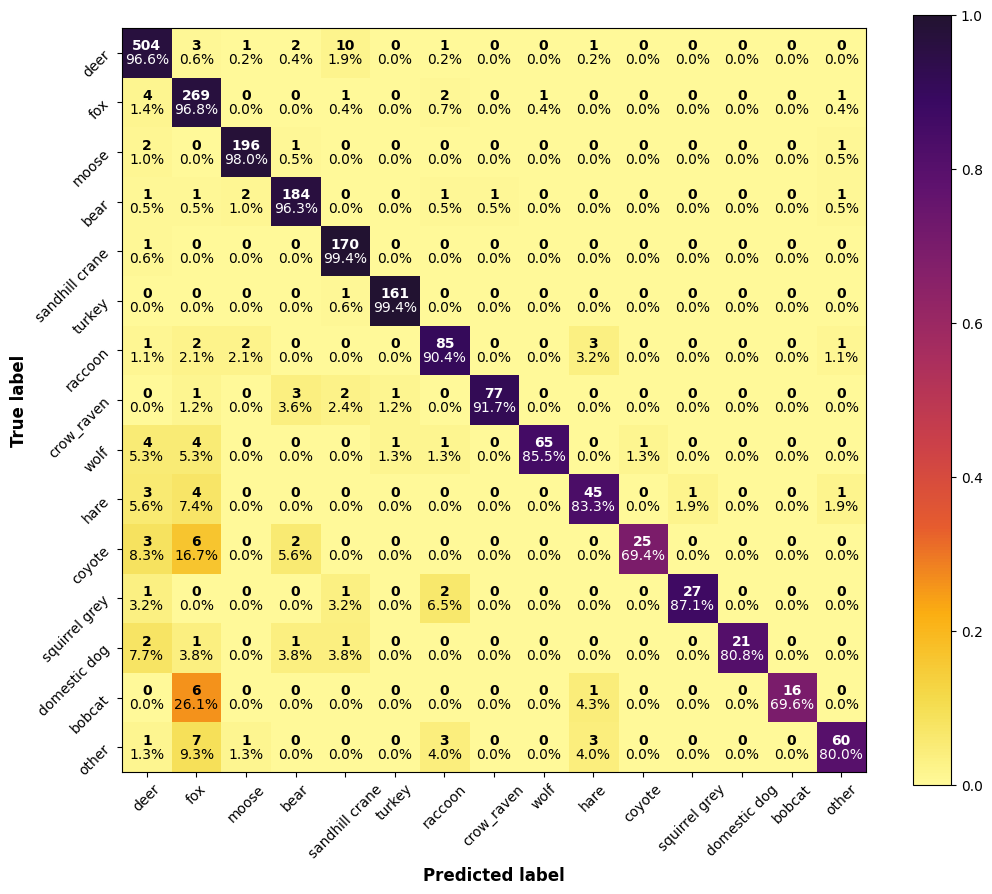

In [93]:
cm = sklearn.metrics.confusion_matrix(true_y, predicted_y)
figureD = generate_confusion_matrix(cm, class_names, colour="dark")

In [94]:
figureD.savefig("/localscratch/hrechter.23673475.0/Updated_ConfMatrix_SPP15.png", dpi=300, bbox_inches='tight')

In [120]:
fullpred = []
for i in y_pred:
    y = y_pred[int(i)]
    fullpred.append(y)

TypeError: only size-1 arrays can be converted to Python scalars

In [112]:
preds = pd.DataFrame(y_pred)

In [126]:
y_preds.shape

AttributeError: 'list' object has no attribute 'shape'

In [125]:
y_preds = y_pred.tolist()

In [128]:
str(y_preds[0])

'[0.00028753792867064476, 3.3755122785805725e-07, 0.9997062087059021, 6.696878784850924e-08, 3.6078194654010076e-08, 1.833045104593367e-10, 2.8144124826212646e-06, 1.1950311851194328e-09, 1.3611557960757636e-06, 1.0164552577407449e-07, 3.72593120800957e-08, 1.6050626383545818e-09, 2.8429106291305573e-11, 3.8573155336507625e-08, 1.280406763726205e-06]'

In [144]:
newdf = pd.DataFrame(y_pred)

In [145]:
newdf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.875379e-04,3.375512e-07,9.997062e-01,6.696879e-08,3.607819e-08,1.833045e-10,2.814412e-06,1.195031e-09,1.361156e-06,1.016455e-07,3.725931e-08,1.605063e-09,2.842911e-11,3.857316e-08,1.280407e-06
1,8.951699e-06,1.113205e-06,1.616573e-07,1.337734e-05,6.460062e-06,1.627166e-05,2.573364e-05,9.994065e-01,2.803807e-05,2.573088e-06,2.293885e-06,4.829499e-04,2.319310e-06,1.087751e-07,3.127567e-06
2,1.179886e-06,3.195562e-11,9.999988e-01,2.342764e-09,2.952523e-14,4.684559e-16,1.765484e-11,8.178930e-15,1.735951e-10,4.021041e-12,7.689259e-11,1.260924e-15,1.662729e-14,6.291652e-13,3.534363e-09
3,1.059020e-12,1.000000e+00,7.043076e-16,7.447297e-14,6.666763e-12,2.605292e-14,9.444225e-11,1.013027e-15,1.161392e-13,7.165282e-12,4.527170e-12,1.735779e-15,3.099880e-14,7.423829e-13,3.065186e-10
4,1.107751e-04,9.997420e-01,2.217817e-08,2.944784e-08,8.091687e-07,2.067233e-11,9.655367e-07,7.249923e-11,1.453073e-04,6.618806e-11,2.223892e-07,1.342484e-10,4.959302e-10,4.900125e-09,2.089156e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,5.004155e-10,9.999983e-01,1.947802e-09,1.923774e-09,1.387620e-10,4.499024e-12,9.556351e-08,8.627283e-09,5.451007e-09,2.690168e-07,2.774528e-09,2.370258e-12,6.276936e-11,8.474010e-10,1.239199e-06
2019,1.060956e-02,1.668495e-05,8.432209e-06,1.631726e-07,9.892728e-01,8.006521e-06,4.218479e-08,4.246541e-08,5.027257e-08,1.118995e-09,2.284371e-06,1.197417e-08,8.123982e-05,4.186572e-07,1.638553e-07
2020,1.000000e+00,7.418391e-10,1.604141e-13,2.631132e-13,2.454285e-14,3.714937e-17,1.080775e-11,4.513046e-17,3.404308e-09,3.455819e-14,1.018241e-09,2.605813e-15,5.809699e-12,2.684033e-10,1.569325e-11
2021,4.727257e-09,6.625929e-07,4.001945e-12,5.213434e-11,1.462570e-14,8.588796e-15,3.388727e-11,4.194141e-11,9.999992e-01,1.487822e-11,9.653252e-08,1.491215e-14,3.946173e-12,5.464676e-10,1.005544e-11


In [139]:
def generate_df(path, class_true, class_pred, all_pred, classes):
    
    df=pd.DataFrame()
    image_path=path.tolist()
    df['image_path']=image_path
    
    class_dict = dict(enumerate(classes))
    
    true_class=(class_true.astype(int)).tolist()
    df['true_class']=pd.DataFrame(true_class)
    df['true_animal'] = df['true_class'].apply(lambda x: class_dict[x])

    pred_class=(class_pred.astype(int)).tolist()
    df['pred_class']=pd.DataFrame(pred_class)
    df['pred_animal'] = df['pred_class'].apply(lambda x: class_dict[x])
    return df
    

In [147]:
np.savetxt("/localscratch/hrechter.23673475.0/SPP15_pred_array.txt", y_pred)

In [140]:
results_df = generate_df(test_paths, true_y, predicted_y, y_pred, class_names)

In [142]:
results_df.to_csv("/localscratch/hrechter.23673475.0/SPP15_df.csv", index=False)

In [146]:
newdf.to_csv("/localscratch/hrechter.23673475.0/SPP15_y_preds_df.csv", index=False)

In [ ]:
df=pd.DataFrame()
image_path=test_paths.tolist()
df['image_path']=image_path

class_dict = dict(enumerate(classes))

true_class=(class_true.astype(int)).tolist()
df['true_class']=pd.DataFrame(true_class)
df['true_animal'] = df['true_class'].apply(lambda x: class_dict[x])

pred_class=(class_pred.astype(int)).tolist()
df['pred_class']=pd.DataFrame(pred_class)
df['pred_animal'] = df['pred_class'].apply(lambda x: class_dict[x])

all_pred=(class_pred.astype(int)).tolist()
df['full_prediction']=pd.DataFrame(all_pred)
df.to_csv('Results/imagepreds.csv')

In [32]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Y = np.array(train['id'])
group=None

In [17]:
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=4)
split = splitter.split(df, y=Y, groups=df['CT_location'])
train_index, test_index = next(split)
train = df.iloc[train_index]
test_df = df.iloc[test_index]
print("Seed #4")
print(test_df[['Species', 'id']].value_counts().reset_index(name='count'))
group = get_group(df, "CT_loc")
test_group = np.unique(group[test_index])

Seed #4
          Species  id  count
0            deer   0    620
1             fox   1    228
2            bear   3    222
3           moose   2    180
4  sandhill crane   4    122
5            wolf   5     52
6          bobcat   6     21


In [33]:
import statistics


In [19]:
kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
Y = np.array(train['id'])
group = get_group(train, "CT_loc")
group_name="CTloc"

In [34]:
def get_train_weights(train_df, empties_length, SPP_BAL=True):
    class_weights = []
    night_weights=[]
    n_spp = train_df.id.nunique()
    if SPP_BAL==True:
        max_id_count = empties_length/n_spp
        for i in range(0, n_spp):
            class_weights.append((max_id_count - len(train_df.loc[train_df['id']==i]))/empties_length)
            if i !=5:
                night_weights.append((max_id_count - len(train_df.loc[train_df['id']==i]))/empties_length)
    else:
        for i in range(0, n_spp):
            class_weights.append((len(train_df.loc[train_df['id']==i]))/len(train_df))
            if i !=5:
                night_weights.append((len(train_df.loc[train_df['id']==i]))/len(train_df))
#    dw = sum(class_weights)
#    class_weights= [x/dw for x in class_weights]
#    nw = sum(night_weights)
#    night_weights= [x/nw for x in night_weights]
    return class_weights, night_weights

In [46]:
BATCH=64
INSERTS=False
SPP_BAL=False
NIGHT_BAL=False
LOC_BAL=False
UPSAMPLE=False
ADD_UNSEEN=False
MAX_SAMPLE=20000
reports = []

Fold 0:
None
None

Training data length: 
14563
            Species  id  count
0              deer   0   3757
1               fox   1   1998
2             moose   2   1441
3              bear   3   1375
4    sandhill crane   4   1231
5            turkey   5   1168
6           raccoon   6    676
7        crow_raven   7    602
8              wolf   8    550
9              hare   9    392
10           coyote  10    261
11    squirrel grey  11    226
12     domestic dog  12    184
13           bobcat  13    162
14     squirrel red  14    127
15        porcupine  15     94
16  squirrel flying  16     67
17              elk  17     65
18           marten  18     57
19            skunk  19     45
20         blue jay  20     20
21         chipmunk  21     14
22             lynx  22     11
23           grouse  24      9
24           fisher  23      9
25            otter  25      8
26             mink  26      5
27      weasel long  27      5
28              owl  28      4
Epoch 1/5


2024-07-27 21:13:08.875058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 3.0559 - accuracy: 0.1573 - precision: 0.5463 - recall: 0.0041 - top_3_acc: 0.3175 - top_5_acc: 0.4359

2024-07-27 21:14:57.214837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 133s 521ms/step - loss: 3.0559 - accuracy: 0.1573 - precision: 0.5463 - recall: 0.0041 - top_3_acc: 0.3175 - top_5_acc: 0.4359 - val_loss: 2.7602 - val_accuracy: 0.1685 - val_precision: 0.6994 - val_recall: 0.0318 - val_top_3_acc: 0.3797 - val_top_5_acc: 0.5204
Epoch 2/5
227/227 [==============================] - 115s 506ms/step - loss: 2.4187 - accuracy: 0.2195 - precision: 0.5455 - recall: 0.0664 - top_3_acc: 0.4398 - top_5_acc: 0.5862 - val_loss: 2.0401 - val_accuracy: 0.3691 - val_precision: 0.7119 - val_recall: 0.1669 - val_top_3_acc: 0.6272 - val_top_5_acc: 0.7559
Epoch 3/5
227/227 [==============================] - 115s 506ms/step - loss: 2.7018 - accuracy: 0.2090 - precision: 0.4091 - recall: 0.0886 - top_3_acc: 0.4208 - top_5_acc: 0.5688 - val_loss: 4.3531 - val_accuracy: 0.0332 - val_precision: 0.0587 - val_recall: 0.0198 - val_top_3_acc: 0.1339 - val_top_5_acc: 0.2634
Epoch 4/5
227/227 [==============================] - 119s 525ms/s

2024-07-27 21:25:13.006907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 3.1376 - accuracy: 0.1146 - precision: 0.4082 - recall: 0.0014 - top_3_acc: 0.2766 - top_5_acc: 0.3926

2024-07-27 21:26:48.286466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 116s 510ms/step - loss: 3.1376 - accuracy: 0.1146 - precision: 0.4082 - recall: 0.0014 - top_3_acc: 0.2766 - top_5_acc: 0.3926 - val_loss: 3.0098 - val_accuracy: 0.1560 - val_precision: 0.4444 - val_recall: 0.0056 - val_top_3_acc: 0.3164 - val_top_5_acc: 0.4662
Epoch 2/5
227/227 [==============================] - 117s 514ms/step - loss: 2.5185 - accuracy: 0.1934 - precision: 0.4677 - recall: 0.0529 - top_3_acc: 0.4167 - top_5_acc: 0.5637 - val_loss: 2.1854 - val_accuracy: 0.3072 - val_precision: 0.6367 - val_recall: 0.1066 - val_top_3_acc: 0.5991 - val_top_5_acc: 0.7207
Epoch 3/5
227/227 [==============================] - 116s 513ms/step - loss: 2.6444 - accuracy: 0.2075 - precision: 0.4313 - recall: 0.0898 - top_3_acc: 0.4273 - top_5_acc: 0.5709 - val_loss: 2.5743 - val_accuracy: 0.2547 - val_precision: 0.5787 - val_recall: 0.0636 - val_top_3_acc: 0.4933 - val_top_5_acc: 0.6189
Epoch 4/5
227/227 [==============================] - 117s 515ms/s

2024-07-27 21:37:04.162573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 3.0764 - accuracy: 0.1168 - precision: 0.3710 - recall: 0.0016 - top_3_acc: 0.2649 - top_5_acc: 0.3722

2024-07-27 21:38:40.104735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 116s 513ms/step - loss: 3.0764 - accuracy: 0.1168 - precision: 0.3710 - recall: 0.0016 - top_3_acc: 0.2649 - top_5_acc: 0.3722 - val_loss: 3.0008 - val_accuracy: 0.0625 - val_precision: 0.4096 - val_recall: 0.0095 - val_top_3_acc: 0.2704 - val_top_5_acc: 0.4576
Epoch 2/5
227/227 [==============================] - 117s 514ms/step - loss: 2.5462 - accuracy: 0.1795 - precision: 0.3773 - recall: 0.0410 - top_3_acc: 0.3928 - top_5_acc: 0.5544 - val_loss: 2.6124 - val_accuracy: 0.1992 - val_precision: 0.2923 - val_recall: 0.0511 - val_top_3_acc: 0.4791 - val_top_5_acc: 0.6052
Epoch 3/5
227/227 [==============================] - 116s 510ms/step - loss: 2.5573 - accuracy: 0.2083 - precision: 0.3985 - recall: 0.0876 - top_3_acc: 0.4464 - top_5_acc: 0.5914 - val_loss: 2.7201 - val_accuracy: 0.1830 - val_precision: 0.6323 - val_recall: 0.0513 - val_top_3_acc: 0.4300 - val_top_5_acc: 0.5349
Epoch 4/5
227/227 [==============================] - 116s 510ms/s

2024-07-27 21:48:55.290414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 3.1199 - accuracy: 0.1002 - precision: 0.3846 - recall: 0.0014 - top_3_acc: 0.2406 - top_5_acc: 0.3515

2024-07-27 21:50:30.747010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 116s 511ms/step - loss: 3.1199 - accuracy: 0.1002 - precision: 0.3846 - recall: 0.0014 - top_3_acc: 0.2406 - top_5_acc: 0.3515 - val_loss: 2.8155 - val_accuracy: 0.0993 - val_precision: 0.2706 - val_recall: 0.0064 - val_top_3_acc: 0.3867 - val_top_5_acc: 0.5893
Epoch 2/5
227/227 [==============================] - 115s 506ms/step - loss: 2.5750 - accuracy: 0.1836 - precision: 0.3923 - recall: 0.0432 - top_3_acc: 0.4090 - top_5_acc: 0.5695 - val_loss: 2.2778 - val_accuracy: 0.2698 - val_precision: 0.7129 - val_recall: 0.1018 - val_top_3_acc: 0.5555 - val_top_5_acc: 0.6998
Epoch 3/5
227/227 [==============================] - 115s 507ms/step - loss: 2.6845 - accuracy: 0.1854 - precision: 0.3751 - recall: 0.0730 - top_3_acc: 0.4140 - top_5_acc: 0.5560 - val_loss: 2.6658 - val_accuracy: 0.1814 - val_precision: 0.3607 - val_recall: 0.0661 - val_top_3_acc: 0.4495 - val_top_5_acc: 0.5818
Epoch 4/5
227/227 [==============================] - 118s 522ms/s

2024-07-27 22:00:46.415722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - ETA: 0s - loss: 3.0603 - accuracy: 0.1110 - precision: 0.4455 - recall: 0.0034 - top_3_acc: 0.2584 - top_5_acc: 0.3762

2024-07-27 22:02:22.505876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


227/227 [==============================] - 117s 513ms/step - loss: 3.0603 - accuracy: 0.1110 - precision: 0.4455 - recall: 0.0034 - top_3_acc: 0.2584 - top_5_acc: 0.3762 - val_loss: 2.8921 - val_accuracy: 0.1696 - val_precision: 0.6111 - val_recall: 0.0184 - val_top_3_acc: 0.3198 - val_top_5_acc: 0.4556
Epoch 2/5
227/227 [==============================] - 115s 508ms/step - loss: 2.4592 - accuracy: 0.2065 - precision: 0.4203 - recall: 0.0548 - top_3_acc: 0.4263 - top_5_acc: 0.5740 - val_loss: 2.7184 - val_accuracy: 0.2023 - val_precision: 0.4516 - val_recall: 0.1080 - val_top_3_acc: 0.3917 - val_top_5_acc: 0.5614
Epoch 3/5
227/227 [==============================] - 117s 517ms/step - loss: 2.5836 - accuracy: 0.2031 - precision: 0.4016 - recall: 0.0809 - top_3_acc: 0.4273 - top_5_acc: 0.5725 - val_loss: 2.8197 - val_accuracy: 0.1828 - val_precision: 0.3520 - val_recall: 0.1035 - val_top_3_acc: 0.3987 - val_top_5_acc: 0.6127
Epoch 4/5
227/227 [==============================] - 116s 509ms/s

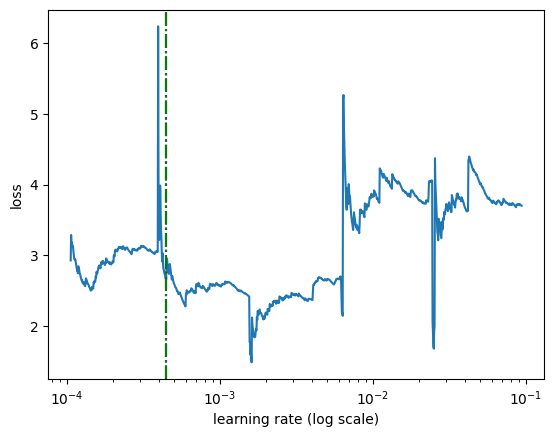

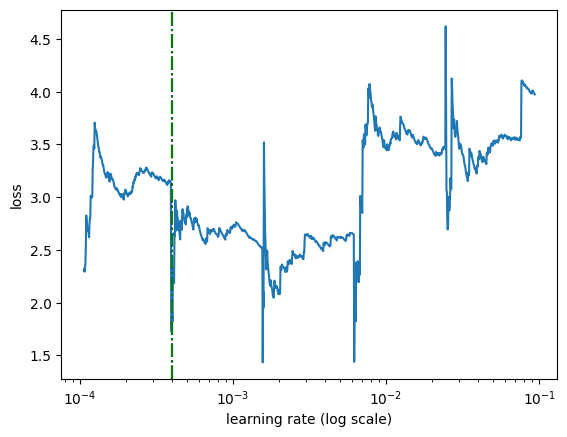

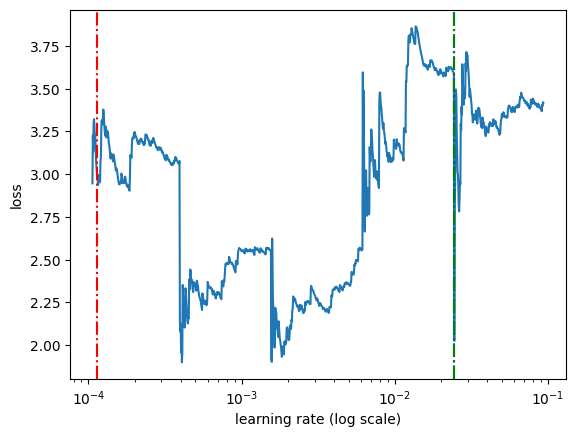

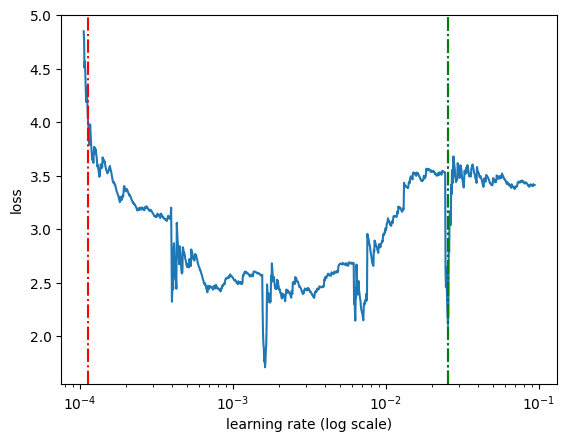

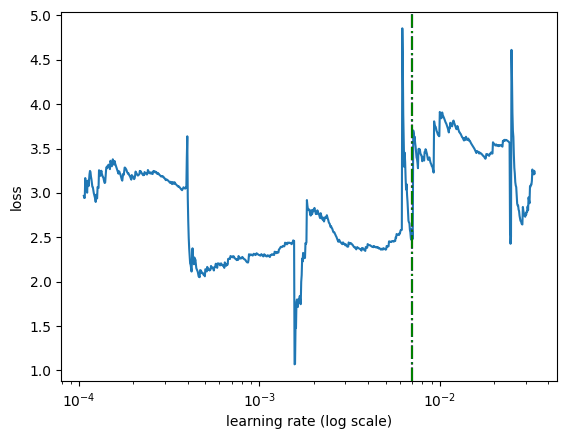

In [47]:
for split, (train_index, val_index) in enumerate(kfold.split(train, Y, group)):
    print(f"Fold {split}:")

    train_df = train.iloc[train_index]
    val_df = train.iloc[val_index]

    train_count=len(train_df)
    val_count=len(val_df)
    train_prop = round((train_count/(train_count+val_count)), 3)
    val_prop = round((val_count/(train_count+val_count)), 3)
    
    y_train = np.array(train_df['id'])
    class_weights = dict(zip(np.unique(y_train),
                             class_weight.compute_class_weight(class_weight = 'balanced',
                                                               classes= np.unique(y_train),
                                                               y= y_train)))    
    if group is not None:
      #  print("Training groups: ", flush=True)
      #  print((np.unique(group[train_index])), flush=True)
      #  print(f"    Train count: {train_count}, train percentage: {train_prop}.", flush=True)
#                    print(train_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
        train_group = np.unique(group[train_index])

        print("\n" + "Validation groups: ", flush=True)
        print((np.unique(group[val_index])), flush=True)
        print(f"    Val count: {val_count}, val percentage: {val_prop}", flush=True)
#                     print(val_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
        val_group = np.unique(group[val_index])
    if INSERTS==True:
        if group_name in ("CTloc"):
            train_empties=empties.loc[empties['CT_location'].isin(train_group)]
            train_empties.loc[:,'id'] = -1
            if ADD_UNSEEN ==True:
                val_empties=empties.loc[empties['CT_location'].isin(val_group)]
                val_empties.loc[:,'id'] = -1
                test_empties=empties.loc[empties['CT_location'].isin(test_group)]
                test_empties.loc[:,'id'] = -1
                train_empties = pd.concat([val_empties, test_empties])
            else:
                val_empties=None
                test_empties=None
        else:
            train_empties = empties.copy()
        train_empties=get_empties(train_df, train_empties, MAX_SAMPLE=MAX_SAMPLE, 
                                  LOC_BAL=LOC_BAL, NIGHT_BAL=NIGHT_BAL, UNSEEN=ADD_UNSEEN)

        if SPP_BAL==True:
            empties_length = len(train_empties.loc[train_empties['id']==-1])
            train_weights, night_weights = get_train_weights(train_df, empties_length, True)
            print(train_weights)
            print(night_weights)
        else:
            empties_length = len(train_empties.loc[train_empties['id']==-1])
            train_weights, night_weights = get_train_weights(train_df, empties_length, False)
            print(train_weights)
            print(night_weights)

    #                      print(np.unique(train_empties['id']))
    #                       print(np.unique(val_empties['id']))
        add_empties = [train_df, train_empties]
        train_df = pd.concat(add_empties)
        print(len(train_df))
    #                        print(len(train_df), flush=True)
    else:
        if UPSAMPLE==True:
            print(train_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)
            print(train_df['path'].nunique())
            train_df = upsample_data(train_df, MAX_SAMPLE)
            print(train_df['path'].nunique())
        train_weights = None
        night_weights = None
    print(train_weights)
    print(night_weights)
    print("\n" + "Training data length: ", flush=True)
    print(len(train_df), flush=True)
    print(train_df[['Species', 'id']].value_counts().reset_index(name='count'), flush=True)

    traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'pathPNG', 'Night': 'Night'},
                                 model_name="DenseNet201", shuffle = True, 
                                 INSERTS=INSERTS, SPP_BAL=SPP_BAL, weights=train_weights, night_weights=night_weights)
    valgen = ValidationDataGenerator(val_df,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'pathPNG'},
                                 model_name="DenseNet201",
                                 shuffle = True)

    STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
    lr_finder = LRFinder(model)
    lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=5, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen, class_weight=class_weights)
    report_df=pd.DataFrame()
    report_df['Fold'] = split
#    report_df[['deer_weights', 'fox_weights', 'moose_weights', 'bear_weights', 'crane_weights', 'wolf_weights', 'bobcat_weights']] = train_weights
  # report_df['class_weights']=class_weights
    report_df['train_count']=train_count
    report_df['val_count']=val_count
 #   report_df['empties_count']=empties_length
    print("Fold: " + str(split))
    best_lr = lr_finder.get_best_lr(sma=20)
    best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=25, sma=20)
    best_3 = lr_finder.get_best_lr(n_skip_beginning=190, n_skip_end=25, sma=20)
    print("Best lr: " + str(best_lr))
    print("Best lr2: " + str(best_2))
    print("Best lr3: " + str(best_3), flush=True)
    axs = plot_loss()
    axs.axvline(x=best_lr, c='r', linestyle='-.')
    axs.axvline(x=best_2, c='b', linestyle='-.')
    axs.axvline(x=best_3, c='g', linestyle='-.')
    reports.append(report_df)

In [32]:
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=50, n_skip_end=300, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=200, n_skip_end=100, sma=20)
axs = plot_loss()
axs.axvline(x=.002, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

ValueError: attempt to get argmin of an empty sequence

In [32]:
report_df[['deer_weights', 'fox_weights', 'moose_weights', 'bear_weights', 'crane_weights', 'wolf_weights', 'bobcat_weights']] = train_weights

In [45]:
report_df

,Fold,deer_weights,fox_weights,moose_weights,bear_weights,crane_weights,wolf_weights,bobcat_weights,train_count,val_count,empties_count


In [66]:
def fig_loss(best_lr, best_2, best_3, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
    """
    Plots the loss.
    Parameters:
        n_skip_beginning - number of batches to skip on the left.
        n_skip_end - number of batches to skip on the right.
        """
    learning_rates = lr_finder.get_learning_rates()
    losses = lr_finder.get_losses()

    f, ax = plt.subplots()
    ax.set_ylabel("loss")
    ax.set_xlabel("learning rate (log scale)")
    ax.plot(learning_rates[n_skip_beginning:-n_skip_end],
            losses[n_skip_beginning:-n_skip_end])
    ax.set_xscale(x_scale)
    
    ax.axvline(x=best_lr, c='r', linestyle='-.')
    ax.axvline(x=best_2, c='b', linestyle='-.')
    ax.axvline(x=best_3, c='g', linestyle='-.')
    return(f)

Best lr: 0.0011672509
Best lr2: 0.0011672509
Best lr3: 0.0011672509


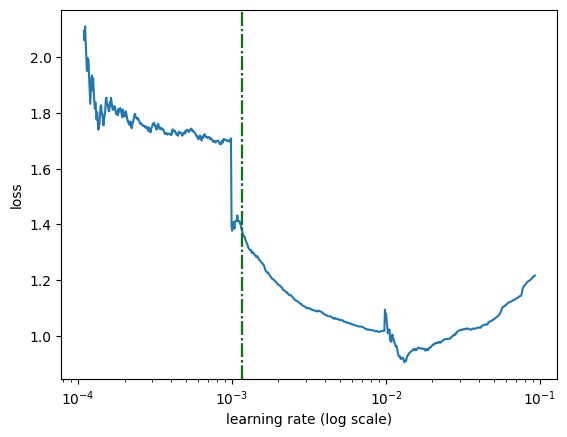

In [67]:
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
fig = fig_loss(best_lr, best_2, best_3)

In [68]:
fig.savefig('Fig1.png')

In [ ]:
traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                 model_name="DenseNet201",
                                 shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                 batch_size = BATCH,
                                 y_col = {'id': 'id', 'domain': 'domain', 
                                          'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                 X_col = {'path': 'path'},
                                 model_name="DenseNet201",
                                 shuffle = True)

history = model.fit(traingen, epochs=1, validation_data=valgen)

/tmp/ipykernel_17960/1031162802.py:188: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_tuple = np.asarray([self.__get_insert_input(x) for x in x_batches])
2024-04-29 12:50:39.177115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 180/1250 [===>..........................] - ETA: 9:32 - loss: 2.0685 - accuracy: 0.3079 - precision: 0.5298 - recall: 0.0918

Best lr: 0.000103883955
Best lr2: 0.0010483077
Best lr3: 0.010331993


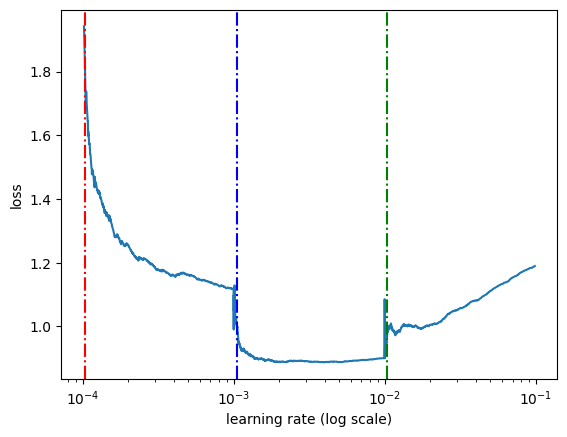

In [25]:
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=50, n_skip_end=1500, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=1300, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [ ]:
train_weights, train_sample = get_train_weights(train_df)
train_weights.pop(18)
train_weights.pop(22)
train_weights.pop(23)
train_weights.pop(23)
print("N empties: " + str(train_sample))
night_weights = (get_train_weights(train_df))[0]
night_weights.pop(3)
night_weights.pop(4)
night_weights.pop(5)
night_weights.pop(7)
night_weights.pop(10)
night_weights.pop(27)
night_weights.pop(28)


if group_name in ("CTloc"):
    train_group = np.unique(group[train_index])
    val_group = np.unique(group[val_index])
    train_empties=empties.loc[empties['Camera_loc'].isin(train_group)]
    val_empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    val_empties['id']=-2
else:
    train_empties = empties.copy()
train_empties=train_empties.sample(train_sample, replace=True)
train_empties['id']=-1


add_empties = [train_df, train_empties] #, val_empties]
train_df = pd.concat(add_empties)

traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=True, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-4, end_lr=1e-1, epochs=3, steps_per_epoch=STEPS_PER_EPOCH, validation_data=valgen)
print("Fold: " + str(split))
best_lr = lr_finder.get_best_lr(sma=20)
best_2 = lr_finder.get_best_lr(n_skip_beginning=25, n_skip_end=5, sma=20)
best_3 = lr_finder.get_best_lr(n_skip_beginning=45, n_skip_end=5, sma=20)
print("Best lr: " + str(best_lr))
print("Best lr2: " + str(best_2))
print("Best lr3: " + str(best_3), flush=True)
axs = plot_loss()
axs.axvline(x=best_lr, c='r', linestyle='-.')
axs.axvline(x=best_2, c='b', linestyle='-.')
axs.axvline(x=best_3, c='g', linestyle='-.')

In [ ]:
STEPS_PER_EPOCH = np.ceil(len(train_df) / BATCH)
lr_finder = LRFinder(model)
lr_finder.find(traingen, start_lr=1e-5, end_lr=1, epochs=5, steps_per_epoch=STEPS_PER_EPOCH)
fig = plot_loss()
best_lr = lr_finder.get_best_lr(sma=20)
print("Best lr: " + str(best_lr), flush=True)

In [ ]:
traingen = TrainingDataGenerator(df=bal_df, crops= crops,
                                         batch_size = BATCH,
                                         y_col = {'id': 'id', 'domain': 'domain', 
                                                  'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                         X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                         model_name="DenseNet201",
                                         shuffle = True, inserts=False) #, weights=train_weights, night_weights=night_weights)
valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)

In [ ]:
axs = plot_loss()
axs.axvline(x=0.005, c='g', linestyle='-.')
print(lr_finder.get_best_lr(n_skip_beginning=20, n_skip_end=290, sma=20))

In [ ]:
for split, (train_index, val_index) in enumerate(kfold.split(df, Y, group)):
    
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    y_train = np.array(train_df['id'])

  #  val_group = np.unique(group[val_index])
  #  empties = empties.loc[empties['Camera_loc']. isin(val_group)]
    empties=empties.sample(1000, replace=False)
    add_empties = [train_df, empties]
    train_df = pd.concat(add_empties)

#    paths, X_train, y_train = get_data(train_df)
 #   testpaths, X_test, y_test = get_data(val_df)
    
    traingen = TrainingDataGenerator(df=train_df, crops= crops,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path', 'Empty': 'Empty', 'Night': 'Night'},
                                     model_name="DenseNet201",
                                     shuffle = True, inserts=False)
    valgen = ValidationDataGenerator(val_df,
                                     batch_size = BATCH,
                                     y_col = {'id': 'id', 'domain': 'domain', 
                                              'sin_date': 'sin_doy', 'cos_date': 'cos_doy'},
                                     X_col = {'path': 'path'},
                                     model_name="DenseNet201",
                                     shuffle = True)